In [1]:
# remove_cell
import sys
sys.path.insert(0, '/home/jovyan/ros/')

%load_ext autoreload
%autoreload 2

In [2]:
# remove_cell 
import itertools as it
import operator

import altair as A
import dscontrib.wbeard as wb
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
import pandas as pd
import scipy.stats as st
from numba import njit
import toolz.curried as z
import seaborn as sns


from ros.utils.common import hstack, vstack, plot_wrap, drop_outliers
from ros.utils import plot as plu
from ros.utils import bootstrap as bs

import dscontrib.wbeard as wb

str_concat = z.compose("-".join, z.map(str))
lmap = z.comp(list, map)
plt.rcParams["font.size"] = 17

Warning, $BQ_CREDS not found in environment


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)


# Build dataset

\begin{align}
fp_{baseline} & \sim \mathrm{Gamma}(4 + \mathbb 1_{win7} \cdot \mu_{win}) \\
w_{treat} & \sim \mathcal N (\mathbb 1_{treat} \cdot \mu_{treat}, \sigma_{treat}) \\
\log(first\_paint) & = fp_{baseline} + w_{treat}
\end{align}

In [7]:
# hide_input
@njit
def seed(n):
    nr.seed(n)

@njit
def randn(mu, sig, size=1):
    return nr.randn(size) * sig + mu

In [8]:
# collapse_show
WIN7_FACT = 1.2
TREAT_MU = np.log(.9)
TREAT_SD = .15


@njit
def gen_log_first_paint_pre_post(win7, treat, size=1):
    pre = nr.gamma(4 + WIN7_FACT * win7, 1, size=size)
    return np.concatenate((pre, pre + randn(TREAT_MU * treat, TREAT_SD, size=size)))

In [6]:
# collapse_hide
n_each = 10_000
n_win_7 = {0: n_each, 1: n_each}
seed(0)


def add_columns(df):
    pre_post = pd.DataFrame(
        [
            gen_log_first_paint_pre_post(win7, treat=treat)
            # gen_pre_post(win7, win7_fact=WIN7_FACT, treat=treat, treat_fact=TREAT_FACT,)
            for win7, treat in df[["win7", "treat"]].itertuples(index=False)
        ],
        columns=["lpre", "lpost"],
    ).assign(
        pre=lambda df: np.exp(df.lpre),
        post=lambda df: np.exp(df.lpost),
    )
    df = hstack([df, pre_post])
    df = (
        df.assign(os=lambda df: df.win7.map({0: "win10", 1: "win7"}))
        .reset_index(drop=0)
        .rename(columns={"index": "id"})
    )
    df["demo"] = [
        str_concat(tup)
        for tup in df[["treat", "os"]]
        .assign(treat=lambda df: df.treat.map({1: "treat", 0: "control"}))
        .itertuples(index=False)
    ]
    return df


def create_test_pop(n_each=50):
    data_dct = [
        {"win7": win7, "treat": treat}
        for win7 in (0, 1)
        for treat in (0, 1)
        for _ in range(n_win_7[win7])
    ]
    df_ = pd.DataFrame(data_dct)
    df = df_.pipe(add_columns)
    return df


def stack_pre_post(df):
    """
    demo[graphic] is concatenated values for
    ["treat", "os"]
    demo2 is for ["treat", "os", "pre"]
    """
    dfs = (
        df.set_index(["id", "win7", "os", "treat", "demo"])
        .stack()
        .reset_index(drop=0)
        .rename(columns={"level_5": "pre", 0: "y"})
        .assign(
            demo2=lambda df: lmap(
                str_concat, df[["demo", "pre"]].itertuples(index=False)
            )
        )
        .assign(pre=lambda df: (df.pre == "pre").astype(int))
    )
    return dfs


treat_i2name = {0: "control", 1: "treat"}
df = create_test_pop()
dfs = stack_pre_post(df.drop(["lpre", "lpost"], axis=1)).assign(
    branch=lambda df: df.treat.map(treat_i2name)
)
df.drop_duplicates("win7")

,id,win7,treat,lpre,lpost,pre,post,os,demo
0,0,0,0,4.307378,4.454188,74.245525,85.986320,win10,control-win10
20000,20000,1,0,4.774024,4.808432,118.394690,122.539269,win7,control-win7


In [6]:
dfs[:3]

,id,win7,os,treat,demo,pre,y,demo2,branch
0,0,0,win10,0,control-win10,1,74.245525,control-win10-pre,control
1,0,0,win10,0,control-win10,0,85.986320,control-win10-post,control
2,1,0,win10,0,control-win10,1,35.188365,control-win10-pre,control


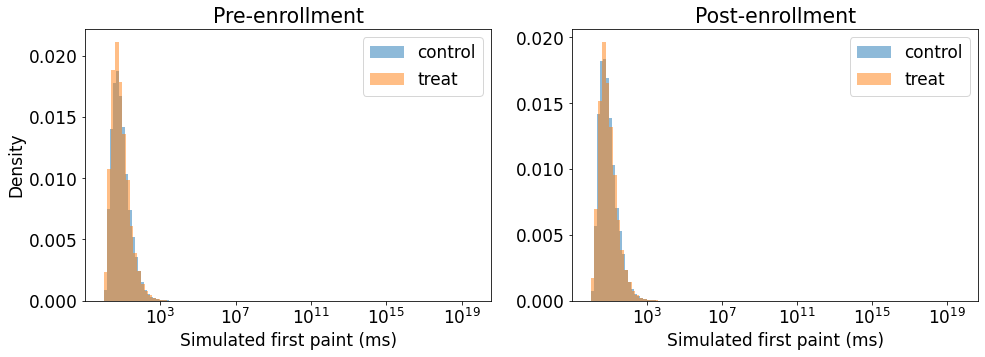

In [7]:
# collapse_hide
axs, spi = wb.plot_utils.mk_sublots(nrows=1, ncols=2, figsize=(16, 5), sharex=False)

for pre, pdf in dfs.groupby("pre"):
    spi.n
    plt.title(["Pre-enrollment", "Post-enrollment"][pre])
    for branch, bdf in pdf.groupby("branch"):
        lbins = np.logspace(0, np.log(bdf.y.max()), 100)
        plt.hist(bdf.y, bins=lbins, density=1, alpha=0.5, label=branch)

    plt.legend()
    plt.xscale("log")

    if not pre:
        plt.ylabel("Density")
    plt.xlabel("Simulated first paint (ms)")

- control: no difference pre/post
- for the treatment groups post is slightly larger than pre

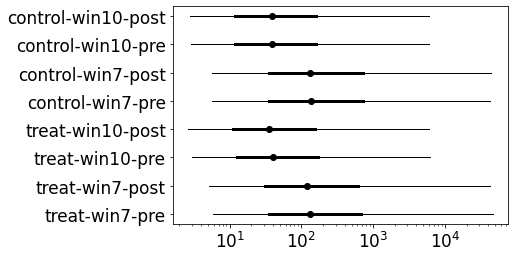

In [9]:
# collapse_hide
plu.plot_groupby(dfs, 'demo2', 'y', quants=[50, 95])
plt.xscale('log')

# Difference in means

In [11]:
# collapse_hide
dfs_pre = dfs.query("pre == 1")
dfs_pre.groupby("branch").y.mean()

branch
control     9317.992199
treat      34222.844459
Name: y, dtype: float64

In [25]:
# collapse_hide


def bootstrap_stat_diff(
    df, gbcol, ycol, stat_fn=np.mean, n_reps=10_000, comp=operator.sub
):
    """
    `gbcol` needs to be col of 0 and 1's, designating
    the groups being compared.
    """
    control = df[ycol][df[gbcol] == 0].values
    treat = df[ycol][df[gbcol] == 1].values
    size = len(control)
    stats = []

    for _ in range(n_reps):
        ac = nr.choice(control, size=size, replace=True)
        at = nr.choice(treat, size=size, replace=True)
        #         stats.append(stat_fn(at) - stat_fn(ac))
        stats.append(comp(stat_fn(at), stat_fn(ac)))

    return np.array(stats)


def uplift(a, b):
    return a / b - 1


def plot_bs(diffs, log=False, title=None, pe=1, ax=None):
    diffs_p = plot_wrap(diffs)
    plu.plot_groupby(
        diffs_p,
        "g",
        "y",
    )
    plt.yticks([0], ["Pre-enrollment" if pe else ""])
    if log:
        plt.xscale("log")
    plt.title(title)


dfs_post = dfs.query("pre == 0").assign(yl=lambda df: df.y.pipe(np.log))

In [ ]:
# collapse_hide

diffs = bootstrap_stat_diff(dfs_post, "treat", "y")
diffs_out_rm = bootstrap_stat_diff(dfs_post.pipe(drop_outliers), "treat", "y")
diffs_log = bootstrap_stat_diff(dfs_post, "treat", "yl")
diffs_gmean = bootstrap_stat_diff(dfs_post, "treat", "y", stat_fn=st.gmean)
ul_out_rm = bootstrap_stat_diff(dfs_post.pipe(drop_outliers), 'treat', 'y', comp=uplift)
ul = bootstrap_stat_diff(dfs_post, 'treat', 'y', comp=uplift)

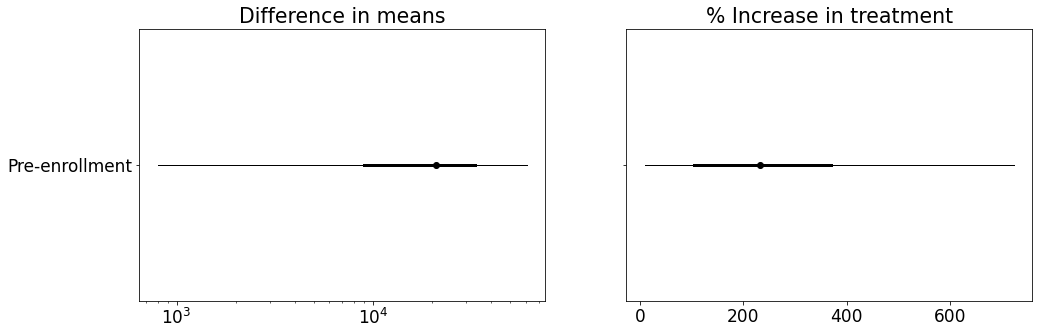

In [34]:
# hide_input
axs, spi = wb.plot_utils.mk_sublots(nrows=1, ncols=2, figsize=(16, 5), sharex=False)

plot_bs(diffs, log=1, title='Difference in means', ax=spi.n)
plot_bs(ul * 100, log=0, title='% Increase in treatment', pe=0, ax=spi.n)

In [59]:
# hide_input
dfs_post.sort_values('y', ascending=False)[:5][['branch', 'y']][::-1].reset_index(drop=1)

,branch,y
0,treat,3.222020e+07
1,treat,3.610928e+07
2,treat,4.309360e+07
3,treat,5.817939e+07
4,treat,3.184504e+08


In [54]:
# collapse_hide
dfs_post.query("yl > 16")[['branch', 'y']].sort_values('y', ascending=True).reset_index(drop=1)

,branch,y
0,control,1.093592e+07
1,control,1.155060e+07
2,treat,3.222020e+07
3,treat,3.610928e+07
4,treat,4.309360e+07
5,treat,5.817939e+07
6,treat,3.184504e+08


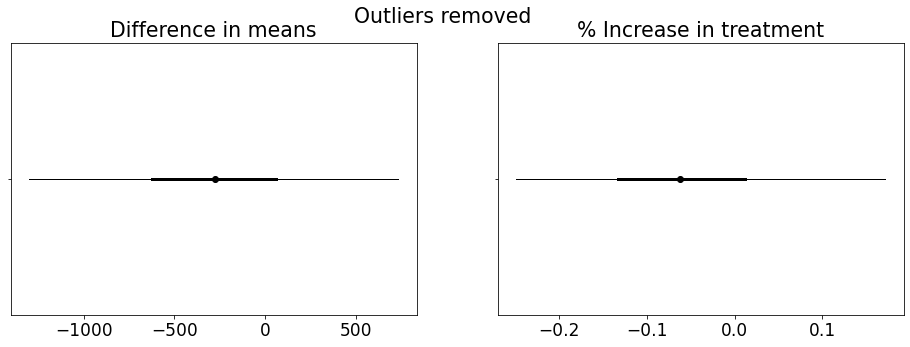

In [43]:
axs, spi = wb.plot_utils.mk_sublots(nrows=1, ncols=2, figsize=(16, 5))

plot_bs(diffs_out_rm, log=0, title='Difference in means', pe=0, ax=spi.n)

plot_bs(ul_out_rm, log=0, title='% Increase in treatment', pe=0, ax=spi.n)
plt.suptitle("Outliers removed");

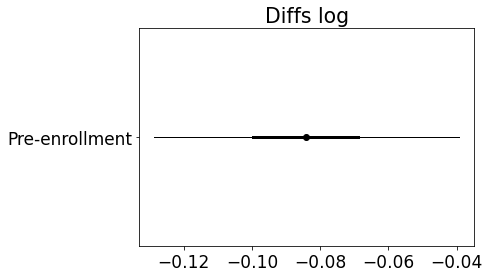

In [44]:
plot_bs(diffs_log, log=0, title='Diffs log')

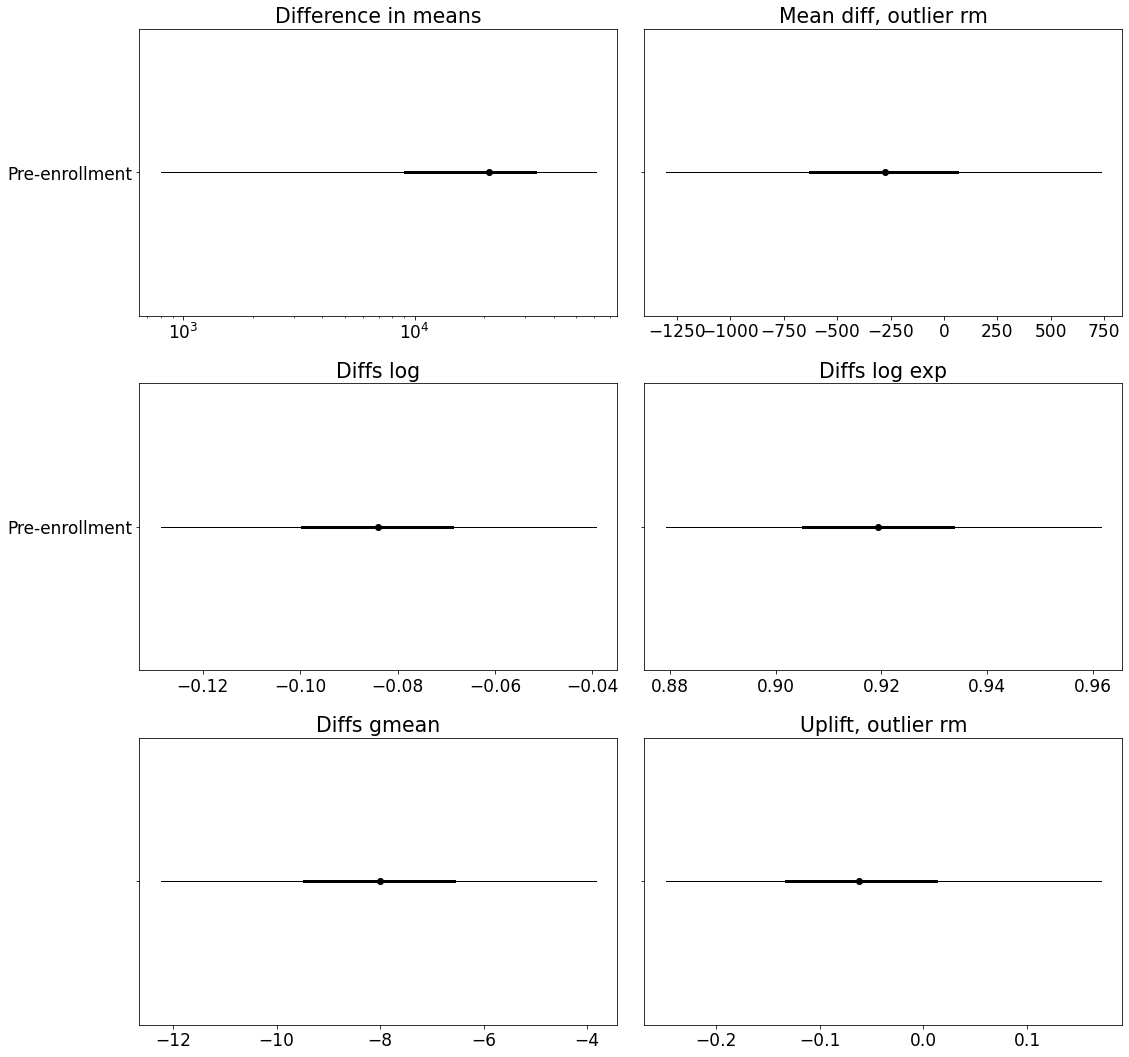

In [18]:
axs, spi = wb.plot_utils.mk_sublots(nrows=3, ncols=2, figsize=(16, 15))

spi.n
plot_bs(diffs, log=1, title='Difference in means')

spi.n
plot_bs(diffs_out_rm, log=0, title='Mean diff, outlier rm', pe=0)

spi.n
plot_bs(diffs_log, log=0, title='Diffs log')

spi.n
plot_bs(np.exp(diffs_log), log=0, title='Diffs log exp', pe=0)

spi.n
plot_bs(diffs_gmean, log=0, title='Diffs gmean', pe=0)

spi.n
plot_bs(ul_out_rm, log=0, title='Uplift, outlier rm', pe=0)

plt.tight_layout()

In [37]:
dfs_pre.assign(
    yl=lambda df: df.y.pipe(np.log)
).groupby("treatn").yl.mean()

treatn
control    4.600171
treat      4.620200
Name: yl, dtype: float64

Top .01%

## As linear regression

In [64]:
from bambi import Model
import arviz as az

data = dfs.assign(yl=lambda df: df.y.pipe(np.log))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [65]:
data[:3]

,id,win7,os,treat,demo,pre,y,demo2,branch,yl
0,0,0,win10,0,control-win10,1,74.245525,control-win10-pre,control,4.307378
1,0,0,win10,0,control-win10,0,85.986320,control-win10-post,control,4.454188
2,1,0,win10,0,control-win10,1,35.188365,control-win10-pre,control,3.560715


In [66]:
mod = Model(data.query("pre == 0").copy())

In [67]:
fit = mod.fit("yl ~ treat", samples=1000, chains=4, target_accept=.8)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 2 jobs)
NUTS: [yl_sd, treat, Intercept]
INFO:pymc3:NUTS: [yl_sd, treat, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `

In [68]:
posterior_treatment = plot_wrap(fit.posterior.treat.values.ravel())

In [72]:
post_plus_boot = vstack([
    plot_wrap(diffs_log).assign(g='bootstrapped_mean'),
    posterior_treatment.assign(g='linear model posterior')
])

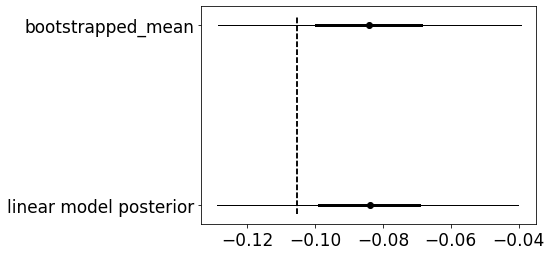

In [73]:
plu.plot_groupby(post_plus_boot, 'g', 'y')
yo, yi = plt.ylim()
plt.vlines([TREAT_MU, TREAT_MU], yo, yi, linestyles='dashed');

# Blocking

In [74]:
df.groupby(['os', 'treat']).post.median().unstack()

treat,0,1
os,,
win10,39.077695,35.76085
win7,133.560365,119.24392


In [75]:
df_pre_post = df.assign(pre_l=lambda df: df.pre.pipe(np.log), post_l=lambda df: df.post.pipe(np.log))
mod_block = Model(df_pre_post.copy())

In [81]:
fit_block = mod_block.fit("post_l ~ treat + win7", samples=1000, chains=4, backend='pymc3')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 2 jobs)
NUTS: [post_l_sd, win7, treat, Intercept]
INFO:pymc3:NUTS: [post_l_sd, win7, treat, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [82]:
posterior_treatment_block = plot_wrap(fit_block.posterior.treat.values.ravel())

In [ ]:
fit_block_baseline = mod_block.fit("post_l ~ pre_l + treat + win7", samples=1000, chains=4)

In [83]:
posterior_treatment_block_bl = plot_wrap(fit_block_baseline.posterior.treat.values.ravel())

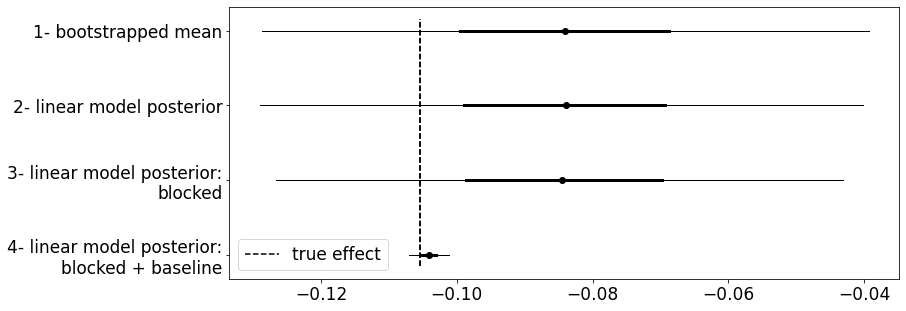

In [93]:
plt.figure(figsize=(12, 5))
post_boot_block = vstack([
    posterior_treatment.assign(g='2- linear model posterior'),
    posterior_treatment_block.assign(g='3- linear model posterior:\nblocked'),
    posterior_treatment_block_bl.assign(g='4- linear model posterior:\nblocked + baseline'),
    plot_wrap(diffs_log).assign(g='1- bootstrapped mean'),
])

plu.plot_groupby(post_boot_block, 'g', 'y', quants=[50, 95], label='_no_label_')
yo, yi = plt.ylim()
plt.vlines([TREAT_MU, TREAT_MU], yo, yi, linestyles='dashed', label='true effect')
plt.legend();

INFO:numba.core.transforms:finding looplift candidates


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f93ec6e8810>],
      dtype=object)

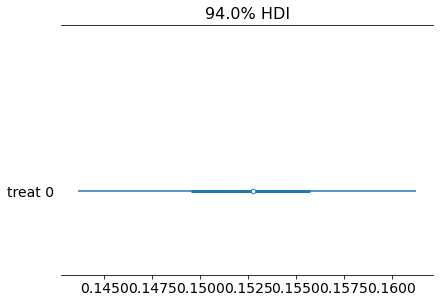

In [37]:
# 'pre_l',  'win7'
az.plot_forest(fit_block, var_names=['treat', ], combined=True)

In [209]:
TREAT_FACT

0.6

In [196]:
az.summary(fit_block)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],-0.013,0.021,-0.053,0.024,0.0,0.0,2388.0,2047.0,2391.0,2238.0,1.0
pre_l[0],1.008,0.009,0.992,1.025,0.0,0.0,2584.0,2584.0,2590.0,2301.0,1.0
treat[0],0.259,0.015,0.230,0.286,0.0,0.0,3062.0,3062.0,3071.0,2187.0,1.0
win7[0],0.009,0.016,-0.018,0.040,0.0,0.0,3585.0,2304.0,3573.0,2752.0,1.0
post_l_sd,0.106,0.006,0.096,0.116,0.0,0.0,2839.0,2839.0,2810.0,1712.0,1.0


In [193]:
df_pre_post[:3]

,id,win7,treat,pre,post,os,demo,pre_l,post_l
0,0,0,0,94.687720,96.608654,win10,control-win10,1.976294,1.985016
1,1,0,0,6.234990,5.454784,win10,control-win10,0.794836,0.736778
2,2,0,0,4.155166,4.699156,win10,control-win10,0.618588,0.672020


In [191]:
df_pre_post[:3]

,id,win7,treat,pre,post,os,demo,pre_l,post_l
0,0,0,0,94.687720,96.608654,win10,control-win10,1.976294,1.985016
1,1,0,0,6.234990,5.454784,win10,control-win10,0.794836,0.736778
2,2,0,0,4.155166,4.699156,win10,control-win10,0.618588,0.672020


In [185]:
data[:3]

,id,win7,os,treat,demo,pre,y,demo2,yl
0,0,0,win10,0,control-win10,1,94.687720,control-win10-pre,1.976294
1,0,0,win10,0,control-win10,0,96.608654,control-win10-post,1.985016
2,1,0,win10,0,control-win10,1,6.234990,control-win10-pre,0.794836


# Plots

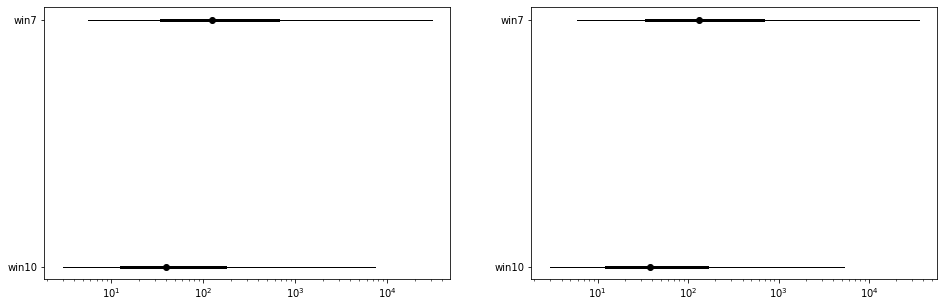

In [85]:
import dscontrib.wbeard as wb
axs, spi = wb.plot_utils.mk_sublots(nrows=1, ncols=2, figsize=(16, 5))

spi.n
df = create_test_pop(5000)
plu.plot_groupby(df, 'os', 'pre')
plt.xscale('log')

spi.n
df = create_test_pop(5000)
plu.plot_groupby(df, 'os', 'pre')
plt.xscale('log')

In [7]:
def mk_bootstrap_df(bs_dct, n_reps=1_000):
    dfs = [
        pd.DataFrame({'y': bs.draw_replicates(n_reps)}).assign(g=k)
        for k, bs in bs_dct.items()
    ]
    df = pd.concat(dfs)
    return df

means_ = {
    k: wb.bootstrap.BootstrapStat(gdf.pre, stat=np.mean)
    for k, gdf in df.groupby('os')
}
mean_draws = mk_bootstrap_df(means_, n_reps=10_000)

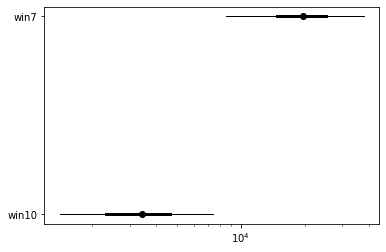

In [9]:
plu.plot_groupby(mean_draws, 'g', 'y', quants=[50, 95])
plt.xscale('log')

In [10]:
df[:3]

,win7,pre,post,os
0,0,28.457386,35.924005,win10
1,0,92.697897,158.996297,win10
2,0,31.821052,57.778453,win10


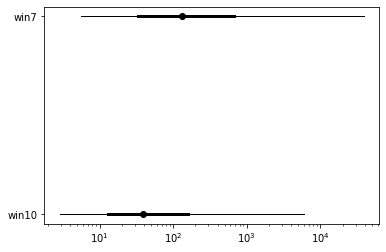

In [25]:

df = create_test_pop(5000)

plot_groupby(df.assign(os=lambda df: df.win7.map({0: 'win10', 1: 'win7'})), 'os', 'pre')

plt.xscale('log')

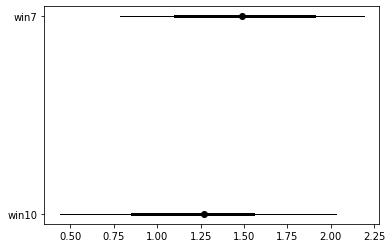

In [37]:

        
plot_probs(sp)

In [56]:
df.groupby(['win7'])[['pre', 'treat']].quantile([.025, .25, .75, .975]).unstack()
# .T.unstack()

pre                                   treat                      \
         0.025     0.250     0.750     0.975     0.025     0.250     0.750   
win7                                                                         
0     1.291482  2.291133  4.832630  6.746378  2.187699  3.440991  6.001139   
1     1.893204  3.907341  6.753467  9.801736  2.651389  4.877444  8.005081   

                 
          0.975  
win7             
0      7.809183  
1     10.797514

In [37]:
df.groupby('win7').pre.mean()

win7
0    3.943179
1    5.037273
Name: pre, dtype: float64

In [25]:

for win7, gdf in df.groupby('win7'):
    1
    
del win7

In [26]:
win7_factor = 1.2

0      2.478191
1      5.925980
2      3.496899
3      2.763261
4      4.099979
         ...   
195    6.584048
196    4.732905
197    8.471105
198    5.075637
199    6.515102
Name: win7, Length: 200, dtype: float64

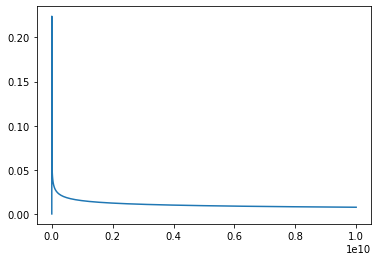

In [10]:
plt.plot(10 ** xs, ys)

# Junk

In [ ]:
def gen_times(win7):
    times = st.gamma(4 + win7_factor * win7).rvs(len(gdf))
    return times

def gen_times_shape(gshape):
    times = st.gamma(gshape).rvs(len(gdf))
    return times

In [ ]:


def gamma_shape(win7):
    return 4 + win7_factor * win7
    
def add_columns(df):
    df['gshape'] = gamma_shape(df.win7)
#     df['pre'] = df.groupby('win7').win7.transform(gen_times)
    df['pre'] = df.groupby('win7').gshape.transform(gen_times_shape)
    df['treat'] = df['pre'] + nr.randn(len(df)) * .25 + 1
    return df

df = pd.DataFrame(data_dct)
df = df.pipe(add_columns)
df.drop_duplicates()